In [1]:
import os
import sys
import gc
# assuming data, models, engine in flicc directory:
flicc_path = os.path.realpath("__file__").split('grid_search')[0]
sys.path.append(flicc_path)
import torch
from data import ClimateDataset
from models import ClassificationModel
from engine import Engine

In [2]:
model_checkpoint='roberta-large'

In [3]:
results = {'test_acc':[],
           'test_f1':[],
           'eval_acc':[],
           'eval_f1':[],
           'g':[]}

In [4]:
gamma = [2,4,8,16]
lr = 1.0e-5

for g in gamma:
    print(f'Grid search {model_checkpoint}, learning rate {lr}, focal loss gamma {g}')
    data = ClimateDataset(model_to_train=1,model_checkpoint=model_checkpoint,dataset_url=flicc_path,batch_size=16)
    data.setup_dataloaders()
    model = ClassificationModel(model_checkpoint=data.model_checkpoint,num_labels=data.num_labels)
    trainer = Engine(epochs=30,labels=data.labels)
    trainer.model = model.model
    trainer.dataset_encoded = data.dataset_encoded
    test_acc, test_f1, eval_acc, eval_f1 = trainer.run(lr=lr,
                                                       wd=0.0,
                                                       train_dataloader=data.train_dataloader,
                                                       eval_dataloader=data.eval_dataloader,
                                                       test_dataloader=data.test_dataloader,
                                                       focalloss=True,
                                                       gamma=g,
                                                       accumulation_steps=2,
                                                       early_stop=3)
    results['test_acc'].append(test_acc)
    results['test_f1'].append(test_f1)
    results['eval_acc'].append(eval_acc)
    results['eval_f1'].append(eval_f1)
    results['g'].append(g)
    print('### '*10)
    print(results)
    print('### '*10)
    with torch.no_grad():
        torch.cuda.empty_cache()
    del data, model, trainer, test_acc, test_f1, eval_acc, eval_f1
    gc.collect()

Grid search roberta-large, learning rate 1e-05, focal loss gamma 2


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.out_proj.weight', 'classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


1 / 30: Train Loss:	0.1746	Val Loss:	0.5704	Accuracy:	0.8228	F1:	0.7471
2 / 30: Train Loss:	0.1253	Val Loss:	0.5441	Accuracy:	0.7571	F1:	0.7335
3 / 30: Train Loss:	0.0888	Val Loss:	0.4125	Accuracy:	0.8621	F1:	0.8303
4 / 30: Train Loss:	0.0600	Val Loss:	0.3417	Accuracy:	0.8687	F1:	0.8296
5 / 30: Train Loss:	0.0336	Val Loss:	0.3171	Accuracy:	0.8709	F1:	0.8145
6 / 30: Train Loss:	0.0406	Val Loss:	0.6483	Accuracy:	0.6958	F1:	0.6836
No improvement for 3 epochs. Stopping early.
best (higgest macro f1-score) val results:
              precision    recall  f1-score   support

       bknow       0.70      0.82      0.76       119
      struct       0.93      0.88      0.90       338

    accuracy                           0.86       457
   macro avg       0.82      0.85      0.83       457
weighted avg       0.87      0.86      0.87       457

test results:
              precision    recall  f1-score   support

       bknow       0.59      0.79      0.68        67
      struct       0.92      0

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.out_proj.weight', 'classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


1 / 30: Train Loss:	0.0478	Val Loss:	0.6340	Accuracy:	0.7965	F1:	0.7190
2 / 30: Train Loss:	0.0366	Val Loss:	0.6089	Accuracy:	0.7637	F1:	0.7396
3 / 30: Train Loss:	0.0285	Val Loss:	0.5105	Accuracy:	0.8425	F1:	0.8065
4 / 30: Train Loss:	0.0201	Val Loss:	0.4073	Accuracy:	0.8731	F1:	0.8285
5 / 30: Train Loss:	0.0162	Val Loss:	0.4039	Accuracy:	0.8687	F1:	0.8107
6 / 30: Train Loss:	0.0185	Val Loss:	0.3675	Accuracy:	0.8403	F1:	0.8077
7 / 30: Train Loss:	0.0089	Val Loss:	0.3153	Accuracy:	0.8950	F1:	0.8598
8 / 30: Train Loss:	0.0093	Val Loss:	0.3301	Accuracy:	0.8775	F1:	0.8245
9 / 30: Train Loss:	0.0045	Val Loss:	0.3480	Accuracy:	0.8556	F1:	0.8192
10 / 30: Train Loss:	0.0025	Val Loss:	0.2908	Accuracy:	0.8950	F1:	0.8581
No improvement for 3 epochs. Stopping early.
best (higgest macro f1-score) val results:
              precision    recall  f1-score   support

       bknow       0.83      0.76      0.79       119
      struct       0.92      0.94      0.93       338

    accuracy               

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.out_proj.weight', 'classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


1 / 30: Train Loss:	0.0040	Val Loss:	0.6856	Accuracy:	0.6543	F1:	0.6334
2 / 30: Train Loss:	0.0030	Val Loss:	0.6517	Accuracy:	0.8184	F1:	0.7315
3 / 30: Train Loss:	0.0028	Val Loss:	0.6387	Accuracy:	0.7462	F1:	0.7249
4 / 30: Train Loss:	0.0027	Val Loss:	0.6427	Accuracy:	0.6565	F1:	0.6467
5 / 30: Train Loss:	0.0028	Val Loss:	0.6117	Accuracy:	0.8490	F1:	0.7751
6 / 30: Train Loss:	0.0019	Val Loss:	0.5926	Accuracy:	0.7352	F1:	0.7189
7 / 30: Train Loss:	0.0018	Val Loss:	0.5223	Accuracy:	0.8556	F1:	0.8201
8 / 30: Train Loss:	0.0018	Val Loss:	0.5968	Accuracy:	0.8053	F1:	0.7831
9 / 30: Train Loss:	0.0012	Val Loss:	0.5472	Accuracy:	0.7593	F1:	0.7392
10 / 30: Train Loss:	0.0020	Val Loss:	0.5401	Accuracy:	0.8556	F1:	0.7841
No improvement for 3 epochs. Stopping early.
best (higgest macro f1-score) val results:
              precision    recall  f1-score   support

       bknow       0.70      0.79      0.74       119
      struct       0.92      0.88      0.90       338

    accuracy               

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-large and are newly initialized: ['classifier.out_proj.weight', 'classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
You're using a RobertaTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


1 / 30: Train Loss:	0.0000	Val Loss:	0.6960	Accuracy:	0.4814	F1:	0.4792
2 / 30: Train Loss:	0.0000	Val Loss:	0.6843	Accuracy:	0.7352	F1:	0.5797
3 / 30: Train Loss:	0.0000	Val Loss:	0.6808	Accuracy:	0.7330	F1:	0.6123
4 / 30: Train Loss:	0.0000	Val Loss:	0.6823	Accuracy:	0.7133	F1:	0.6855
5 / 30: Train Loss:	0.0000	Val Loss:	0.6745	Accuracy:	0.7812	F1:	0.6570
6 / 30: Train Loss:	0.0000	Val Loss:	0.6860	Accuracy:	0.7024	F1:	0.6758
7 / 30: Train Loss:	0.0000	Val Loss:	0.6736	Accuracy:	0.8053	F1:	0.7032
8 / 30: Train Loss:	0.0000	Val Loss:	0.6666	Accuracy:	0.8162	F1:	0.7560
9 / 30: Train Loss:	0.0000	Val Loss:	0.6763	Accuracy:	0.7921	F1:	0.7199
10 / 30: Train Loss:	0.0000	Val Loss:	0.6807	Accuracy:	0.7374	F1:	0.7106
11 / 30: Train Loss:	0.0000	Val Loss:	0.6593	Accuracy:	0.7943	F1:	0.6251
No improvement for 3 epochs. Stopping early.
best (higgest macro f1-score) val results:
              precision    recall  f1-score   support

       bknow       0.66      0.61      0.63       119
      str

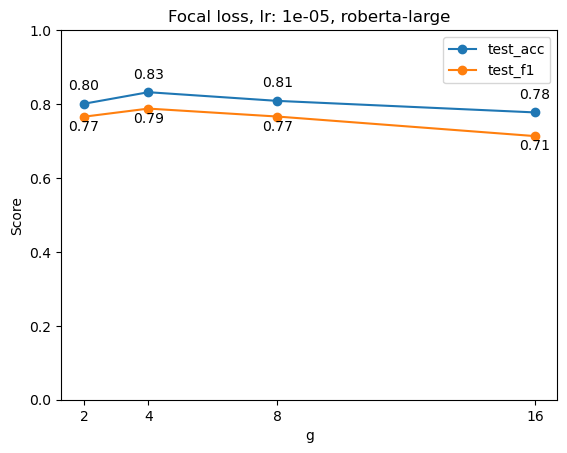

In [5]:
Engine.plot_grid_search(df=results,
                        title=f'Focal loss, lr: {lr}, {model_checkpoint}',
                        column='g',
                        sci_format=False)

In [6]:
%reset -f